In [72]:
import pandas as pd
import re
import string
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV


In [73]:

file_path = "/Users/tanuj/Desktop/SMSSpamCollection"  
df = pd.read_csv(file_path, sep='\t', header=None, names=['label', 'message'])

df['label'] = df['label'].map({'ham': 0, 'spam': 1})


df.head()


,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [74]:

def clean_text(text):
    text = text.lower()  
    text = re.sub(f"[{string.punctuation}]", "", text)  
    text = re.sub(r"\d+", "", text)  
    text = text.strip()  
    return text


df['clean_message'] = df['message'].apply(clean_text)


df[['message', 'clean_message']].head()



,message,clean_message
0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final...
3,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...


/var/folders/s_/mtkgyxj11491fcpb1fstmh200000gn/T/ipykernel_60968/2436696802.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['label'], palette='coolwarm')


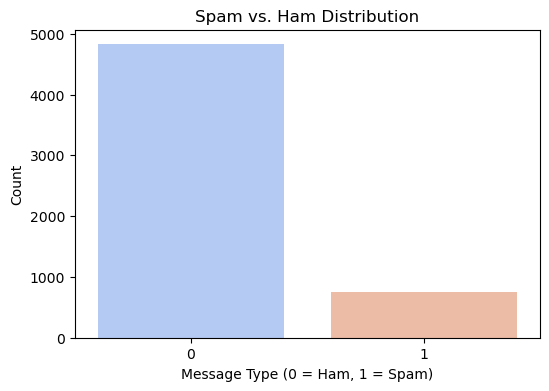

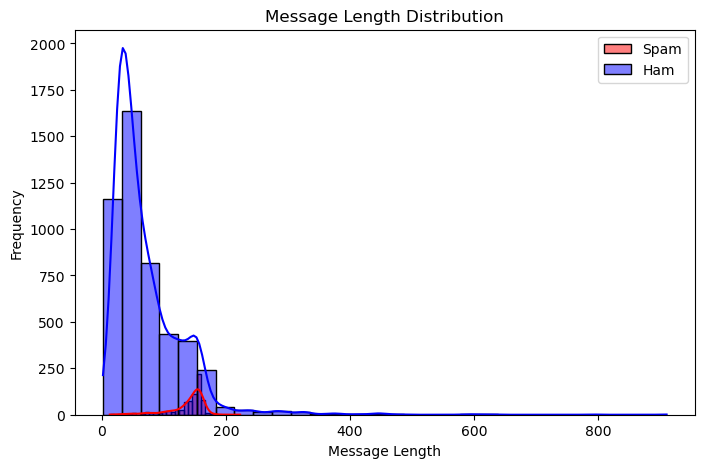

/var/folders/s_/mtkgyxj11491fcpb1fstmh200000gn/T/ipykernel_60968/2436696802.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Coefficient", y="Word", data=top_words_df, hue=None, palette="Purples_r")


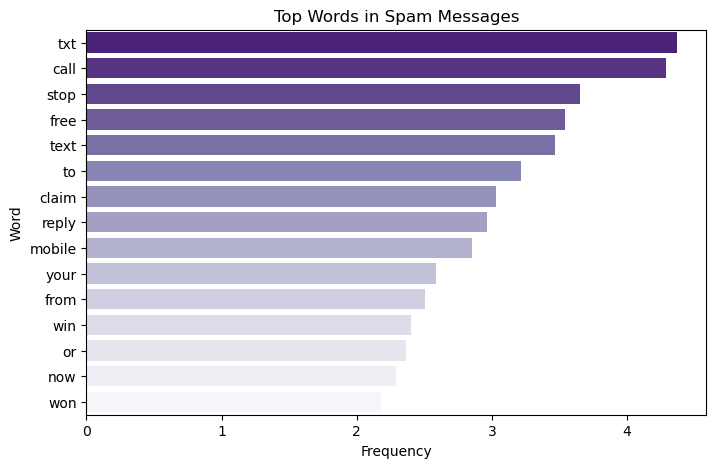

In [75]:

plt.figure(figsize=(6,4))
sns.countplot(x=df['label'], palette='coolwarm')
plt.title('Spam vs. Ham Distribution')
plt.xlabel('Message Type (0 = Ham, 1 = Spam)')
plt.ylabel('Count')
plt.show()


df['message_length'] = df['message'].apply(len)
plt.figure(figsize=(8,5))
sns.histplot(df[df['label']==1]['message_length'], bins=30, color='red', label='Spam', kde=True)
sns.histplot(df[df['label']==0]['message_length'], bins=30, color='blue', label='Ham', kde=True)
plt.legend()
plt.title('Message Length Distribution')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.show()


spam_words = ' '.join(df[df['label']==1]['clean_message'])
spam_word_list = spam_words.split()
spam_word_freq = Counter(spam_word_list)

spam_top_words = pd.DataFrame(spam_word_freq.most_common(15), columns=['Word', 'Frequency'])
plt.figure(figsize=(8,5))
sns.barplot(x="Coefficient", y="Word", data=top_words_df, hue=None, palette="Purples_r")

plt.title('Top Words in Spam Messages')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()


In [76]:

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(df["clean_message"])
y = df["label"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train.shape, X_test.shape


((4457, 5000), (1115, 5000))

In [77]:

nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)
nb_predictions = nb_classifier.predict(X_test)


logistic_regression = LogisticRegression(max_iter=500)  
logistic_regression.fit(X_train, y_train)
lr_predictions = logistic_regression.predict(X_test)


In [78]:

def evaluate_model(y_true, y_pred, model_name):
    print(f"--- {model_name} Performance ---")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred):.4f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred))


evaluate_model(y_test, nb_predictions, "Naïve Bayes")
evaluate_model(y_test, lr_predictions, "Logistic Regression")


--- Naïve Bayes Performance ---
Accuracy: 0.9686
Precision: 1.0000
Recall: 0.7651
F1-Score: 0.8669

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98       966
           1       1.00      0.77      0.87       149

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.97      1115

--- Logistic Regression Performance ---
Accuracy: 0.9677
Precision: 0.9913
Recall: 0.7651
F1-Score: 0.8636

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       966
           1       0.99      0.77      0.86       149

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.97      1115



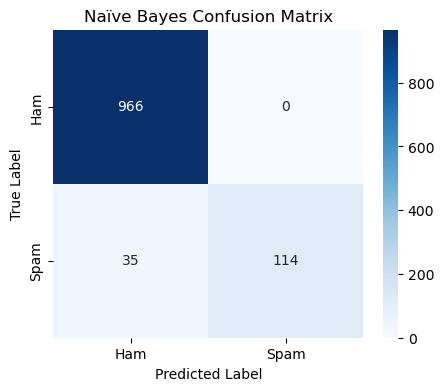

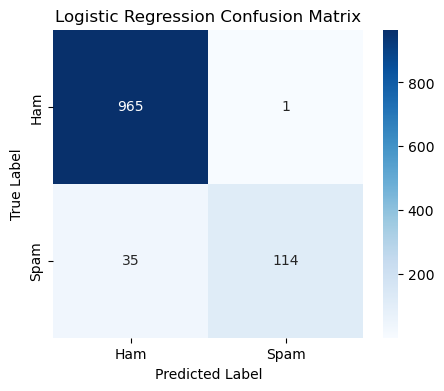

In [79]:

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_test, nb_predictions, title="Naïve Bayes Confusion Matrix")


plot_confusion_matrix(y_test, lr_predictions, title="Logistic Regression Confusion Matrix")


/var/folders/s_/mtkgyxj11491fcpb1fstmh200000gn/T/ipykernel_60968/1957951677.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_words_df['Coefficient'], y=top_words_df['Word'], palette='Purples_r')


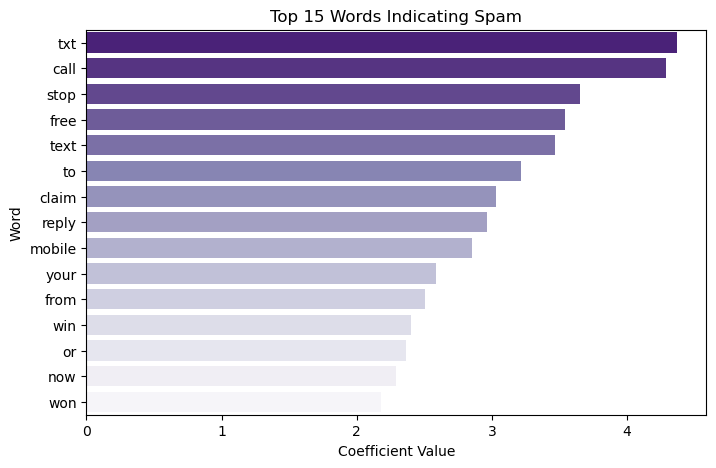

In [80]:

feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = logistic_regression.coef_[0]


top_features = sorted(zip(coefficients, feature_names), reverse=True)[:15]
top_words_df = pd.DataFrame(top_features, columns=['Coefficient', 'Word'])

plt.figure(figsize=(8,5))
sns.barplot(x=top_words_df['Coefficient'], y=top_words_df['Word'], palette='Purples_r')
plt.title('Top 15 Words Indicating Spam')
plt.xlabel('Coefficient Value')
plt.ylabel('Word')
plt.show()


In [81]:

param_grid = {'C': [0.01, 0.1, 1, 10, 100]}


grid_search = GridSearchCV(LogisticRegression(), param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)


print("Best C parameter:", grid_search.best_params_)


logistic_regression = grid_search.best_estimator_
logistic_regression.fit(X_train, y_train)


Best C parameter: {'C': 100}


LogisticRegression(C=100)